In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import non_linearity.utils.constants as ct

from tqdm import tqdm
from non_linearity.environment import Particle
from non_linearity.simulation import simulation
from scipy import signal as sn

In [2]:
freq = 81.5e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 1600 * T
delta_t = T / 400
N_time = int(max_time / delta_t)
t = np.linspace(0, max_time, N_time)
gamma = 65e3

In [3]:
env = Particle(omega, gamma, radius=73e-9)

In [4]:
100*T, (T/4)/delta_t

(0.001226993865030675, 100.0)

In [5]:
env.thermal_force_std

4413218.95448856

In [6]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]/2))
        if not np.isnan(pxx.max()) and not pxx.max() > 1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs)

In [7]:
def generate_traces(env, gain, delta_t, N_time,  M, delay_range):
    cubic_delayed = {i: [None] for i in delay_range}
    print("-- Creating traces --")
    for key in tqdm(cubic_delayed.keys()):
        cubic = np.zeros(shape=(M, N_time))
        for i in range(M):
            data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain*(env.zp_x**3/env.zp_p), key)
            data = np.array(data)
            cubic[i, :] = data
        cubic_delayed[key] = cubic
    print("-- Analysing and making PSD --")
    delay_areas,  areas_std = [], []
    for key in tqdm(list(cubic_delayed.keys())):
        freq, pxx = psd(cubic_delayed[key], delta_t)
        delay_areas.append(pxx.sum(axis=1).mean())
        areas_std.append(pxx.sum(axis=1).std())
    return delay_areas, areas_std

In [8]:
M = 150
delay_range = range(0, 410, 10)
gain= 5.9e5
areas_pos_gain, areas_std_pos_gain = generate_traces(env, gain, delta_t, N_time, M, delay_range)

-- Creating traces --


  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [04:53<00:00,  7.17s/it]


-- Analysing and making PSD --


100%|██████████| 41/41 [07:45<00:00, 11.36s/it]


In [9]:
areas_neg_gain, areas_std_neg_gain = generate_traces(env, -gain, delta_t, N_time, M, delay_range)

-- Creating traces --


100%|██████████| 41/41 [04:44<00:00,  6.93s/it]


-- Analysing and making PSD --


100%|██████████| 41/41 [07:36<00:00, 11.14s/it]


In [10]:
areas_ref, areas_std_ref = generate_traces(env, 0, delta_t, N_time, M, range(0,1,10))

-- Creating traces --


100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


-- Analysing and making PSD --


100%|██████████| 1/1 [00:06<00:00,  6.69s/it]


In [14]:
np.save('../data/delay/simulation/areas_pos_gain.npy', areas_pos_gain)
np.save('../data/delay/simulation/areas_std_pos_gain.npy', areas_std_pos_gain)
np.save('../data/delay/simulation/areas_neg_gain.npy', areas_neg_gain)
np.save('../data/delay/simulation/areas_std_neg_gain.npy', areas_std_neg_gain)
np.save('../data/delay/simulation/areas_ref.npy', areas_ref)
np.save('../data/delay/simulation/areas_std_ref.npy', areas_std_ref)

In [15]:
def autocor_0(t, omega, gamma, m= 3.368e-18, T=293):
    C = 2*(gamma*ct.kb*T/m)
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    T0 = C*np.exp(-gamma*t/2)*(2*Omega*np.cos(Omega*t)+gamma*np.sin(Omega*t))/(4*gamma*Omega*(omega**2))
    return T0


def autocor_perturbation(t, omega, gamma, b, tau, m= 3.368e-18, T=293):
    T0 = autocor_0(t, omega, gamma, m=m)
    C = 2*(gamma*ct.kb*T/m) 
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    mult = np.exp(-gamma*t/2)/(64*(gamma**3)*(Omega**4)*(omega**6))
    part1 = np.exp(gamma*tau/2)*(8*gamma*(Omega**4)-4*(omega**2)*(gamma**2)*(Omega**2)*(t-tau))*np.cos(Omega*(t-tau))
    
    part2 = Omega*np.exp(gamma*tau/2)*(8*gamma*(Omega**2)*(omega**2)*(t-tau)+\
                                       8*(Omega**4)+4*(gamma**2)*(omega**2)+6*(gamma**2)*(Omega**2))*np.sin(Omega*(t-tau))
    part3 = np.exp(-gamma*tau/2)*(Omega**2)*(2*Omega*(gamma**2)-8*(Omega**3))*np.sin(Omega*(t+tau))
    part4 = np.exp(-gamma*tau/2)*8*gamma*(Omega**4)*np.cos(Omega*(t+tau))
    T1 = -3*C*C*b*mult*(part1+part2+part3+part4)
    return T0+T1

def theoretical_area_frac(omega, gamma, gain, delay, m=3.368e-18):
    T0 = autocor_0(0, omega, gamma, m=m)
    T1 = autocor_perturbation(0, omega, gamma, gain, delay, m=m)
    return T1/T0

In [16]:
theory_delays = np.linspace(0, T, 100)
areas_t_pos = theoretical_area_frac(env.__omega__, env.__gamma__, -5.9e5/env._m_, theory_delays, m=env._m_)
areas_t_neg = theoretical_area_frac(env.__omega__, env.__gamma__, 5.9e5/env._m_, theory_delays, m=env._m_)


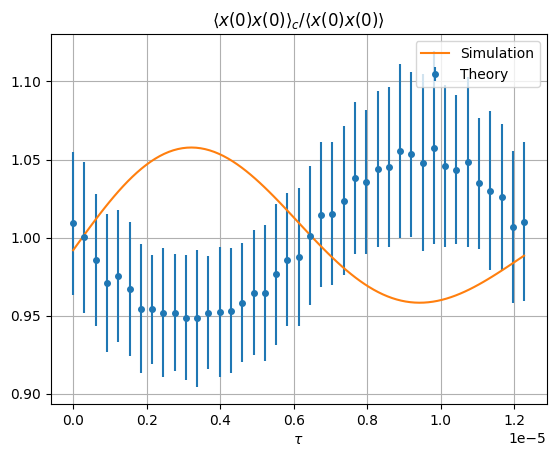

In [18]:
plt.errorbar(np.array(delay_range)*delta_t, np.array(areas_pos_gain)/areas_ref[0], 
             yerr=np.array(areas_std_pos_gain)/(areas_ref[0]), fmt='o', markersize=4)

#plt.errorbar(np.array(delay_range)*delta_t, np.array(areas_neg_gain)/areas_ref[0], 
#             yerr=np.array(areas_std_neg_gain)/(areas_ref[0]), fmt='o', markersize=4)
#plt.errorbar(gains[::5]/1e6, median_shifts[::5]/1e3, yerr=std[::5]/1e3, 
#                fmt='o', color=colors[0], markersize=4)
plt.plot(theory_delays, areas_t_neg)

#plt.plot(theory_delays, areas_t_pos)
plt.legend(['Simulation', 'Theory'])
plt.xlabel(r'$\tau$')
plt.title(r'$\langle x(0)x(0)\rangle_{c}/\langle x(0)x(0)\rangle$')
#plt.ylim([0,2])
plt.grid()
#damped_pxxs.keys()

In [47]:
areas_ref

[92.46689683894077]

In [50]:
areas_std_pos_gain

[2131.625049308682,
 2081.643435131624,
 2055.9590305261413,
 2023.656836441158,
 2062.239024056278,
 2033.2232442835152,
 1918.800159584544,
 2023.278811313603,
 1910.5120135664058,
 1988.2609796311567,
 1924.1703784573256,
 1988.231193512008,
 1928.145838672473,
 1944.44710376859,
 1945.56454440293,
 1990.1299377123958,
 1958.099154538169,
 1932.4557256687158,
 1947.644248750872,
 2076.2676163132573,
 2084.6255497589264,
 2096.0318071866527,
 2108.4446844972995,
 2211.429824877126,
 2229.6403292389195,
 2226.393494778418,
 2247.999778714061,
 2206.62647931421,
 2253.272276379246,
 2257.1698117930064,
 2381.5713144023434,
 2260.348085810439,
 2409.6838815608116,
 2266.5981759298725,
 2241.151032338166,
 2276.6078036343156,
 2272.1068987081203,
 2313.033701205631,
 2142.6131634322264,
 2206.658080224385,
 2160.2190322257584]